<a href="https://colab.research.google.com/github/saeedgolzar/AML_Course/blob/main/Project/Part_3_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Machine Learning Project | Part 3

Saeed Golzar | Summer 2022

Amirkabir University of Technology

---

# Part 3: Sentiment Analysis

Import libraries

In [ ]:
!pip install -q hazm
!pip install -q transformers
!pip install -q clean-text[gpl]

In [2]:
import re
import hazm
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tqdm.auto import tqdm
from cleantext import clean
from google.colab import data_table, files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
data_table.enable_dataframe_formatter()

## Loading data

In [3]:
!gdown 1-9Lb3Q6x7BfYOfmcAmtDHLJ-nuswHxIQ -q

In [4]:
comments = pd.read_excel('dataset.xlsx')
comments.head()

,text,polarity
0,نهایتا، یک دوربین VGA نیز برای انجام مکالمات ...,0.0
1,حتي فرکانس پردازندشم تا 1800 GHz واسه هر هسته ...,0.0
2,اما با اینکه شکل کلی iOS تغییری نداشته است، ول...,1.0
3,به عنوان مثال اگر نیاز به دستگاه های پرینتر، ...,0.0
4,تصاویر گرفته شده با دوربین 8 مگا پیکسلی این گو...,1.0


In [5]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      12000 non-null  object 
 1   polarity  12000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 187.6+ KB


## Basic text preprocessing

----------

- Clean text
- Fixing unicodes
- Removing specials like a phone number, email, url, new lines, ...
- Cleaning HTMLs
- Removing emojis
- Words seperation

In [6]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

def basic_cleaning(text):
  text = text.strip()
    
  # regular cleaning
  text = clean(text,
      fix_unicode=True,
      to_ascii=False,
      lower=True,
      no_line_breaks=True,
      no_urls=True,
      no_emails=True,
      no_phone_numbers=True,
      no_numbers=False,
      no_digits=False,
      no_currency_symbols=True,
      no_punct=False,
      replace_with_url="",
      replace_with_email="",
      replace_with_phone_number="",
      replace_with_number="",
      replace_with_digit="0",
      replace_with_currency_symbol="",
  )

  # cleaning htmls
  text = cleanhtml(text)
  
  # normalizing
  normalizer = hazm.Normalizer()
  text = normalizer.normalize(text)
  
  # removing wierd patterns
  wierd_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # emoticons
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u'\U00010000-\U0010ffff'
      u"\u200d"
      u"\u2640-\u2642"
      u"\u2600-\u2B55"
      u"\u23cf"
      u"\u23e9"
      u"\u231a"
      u"\u3030"
      u"\ufe0f"
      u"\u2069"
      u"\u2066"
      # u"\u200c"
      u"\u2068"
      u"\u2067"
      "]+", flags=re.UNICODE)
  
  text = wierd_pattern.sub(r'', text)
  
  # removing extra spaces, hashtags
  text = re.sub("#", "", text)
  text = re.sub("\s+", " ", text)
  
  return text

## Advanced text preprocessing

----------

- Remove stop words
- Tokenize
- Stemming
- Lemmatization

In [7]:
stop = hazm.utils.stopwords_list()

def lemmatize_text(tokenized_text):
  lemmatizer = hazm.Lemmatizer()
  return [lemmatizer.lemmatize(w) for w in tokenized_text]

def stem_text(tokenized_text):
  stemmer = hazm.Stemmer()
  return [stemmer.stem(w) for w in tokenized_text]


def advance_cleaning(df, col='text_bp', result_col='preprocessed_text'):
  # remove stop words
  df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  # tokenize text
  tqdm.pandas(desc="Tokenize")
  df[result_col] = df[col].progress_apply(hazm.word_tokenize)

  # stemming
  tqdm.pandas(desc="Stemming")
  df[result_col] = df[result_col].progress_apply(stem_text)

  # lemmatization
  tqdm.pandas(desc="Lemmatization")
  df[result_col] = df[result_col].progress_apply(lemmatize_text)

Apply preprocessing on data

In [8]:
#@title Run to use backup file
# !gdown 1oH4-PiWvv_-v1l5mXF5kghIXpIwh84mz -q # load backup file

In [9]:
# apply advance preprocessing
try:
  comments = pd.read_pickle('comments.pkl')
except:
  print('Processed data not found\n')

if 'preprocessed_text' not in comments:
  print('Data must be processed:\n')

  # apply basic preprocessing
  tqdm.pandas(desc="Basic Cleaning")
  comments['text_bp'] = comments['text'].progress_apply(basic_cleaning)

  # tokenize pure text
  comments['text'] = comments['text'].apply(hazm.word_tokenize)
  
  # apply advance preprocessing
  advance_cleaning(comments)

# clean dataframe
comments = comments[['text', 'preprocessed_text', 'polarity']]

# backup data
comments.to_pickle('comments.pkl')

Processed data not found

Data must be processed:



Basic Cleaning:   0%|          | 0/12000 [00:00<?, ?it/s]

Tokenize:   0%|          | 0/12000 [00:00<?, ?it/s]

Stemming:   0%|          | 0/12000 [00:00<?, ?it/s]

Lemmatization:   0%|          | 0/12000 [00:00<?, ?it/s]

In [10]:
comments.head()

,text,preprocessed_text,polarity
0,"[نهایتا, ،, یک, دوربین, VGA, نیز, برای, انجام,...","[نهایتا, ،, دوربین, vga, انجا, مکال, تصویر, قس...",0.0
1,"[حتي, فرکانس, پردازندشم, تا, 1800, GHz, واسه, ...","[فرکانس, پرداخت#پرداز, ۱۸۰۰, ghz, واسه, هسته, ...",0.0
2,"[اما, با, اینکه, شکل, کلی, iOS, تغییری, نداشته...","[شکل, ios, تغییر, نداشته_اس, ،, کمپان, اپل, ،,...",1.0
3,"[به, عنوان, مثال, اگر, نیاز, به, دستگاه, های, ...","[عنو, مثال, دستگاه, پرین, ،, اسکنر, ،, فکس, کپ...",0.0
4,"[تصاویر, گرفته, شده, با, دوربین, 8, مگا, پیکسل...","[تصاویر, دوربین, ۸, مگا, پیکسل, گوش, (, که, سن...",1.0


In [11]:
comments['polarity_IO'] = comments['polarity'].apply(lambda x: 0 if x < 0 else 1)

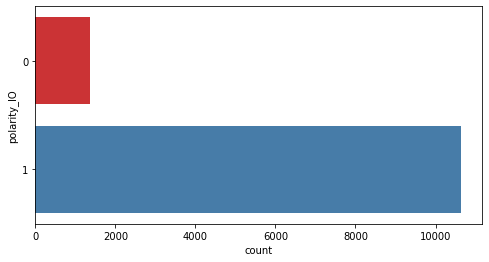

In [12]:
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.countplot(y="polarity_IO", data=comments, palette="Set1")
plt.show()

In [13]:
from numpy import vectorize
def nothing(input):
    return input

def tfidf(tfidf_vectorizer, tokenized_text, flag):
    if flag == 'train':
      tfidf_text = tfidf_vectorizer.fit_transform(tokenized_text)
    else:
      tfidf_text = tfidf_vectorizer.transform(tokenized_text)
    return tfidf_text

def Train_model(X_train, y_train, X_val, y_val):
  # define model
  model = keras.Sequential()
  model.add(keras.layers.Dense(500, activation='relu', input_dim=X_train.shape[1]))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(1000, activation='relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(1000, activation='relu'))
  model.add(keras.layers.Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, validation_freq=1)
  return model, history

def train_val_test_split(X, y):
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)
  return X_train, X_val, X_test, y_train, y_val, y_test

## Tarin model with pure data

In [14]:
lb = LabelEncoder()
y = lb.fit_transform(comments['polarity_IO'])
y = keras.utils.to_categorical(y)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(comments['text'], y)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=nothing, # because we already tokenized text
    preprocessor=nothing, # because we already preprocessed text
    token_pattern=None)

X_train = tfidf(tfidf_vectorizer, X_train, 'train').toarray()
X_val = tfidf(tfidf_vectorizer, X_val, 'val').toarray()
X_test = tfidf(tfidf_vectorizer, X_test, 'test').toarray()

In [15]:
model, history = Train_model(X_train, y_train, X_val, y_val)

Epoch 1/20
240/240 [==============================] - 5s 6ms/step - loss: 0.3192 - accuracy: 0.8850 - val_loss: 0.2959 - val_accuracy: 0.8906
Epoch 2/20
240/240 [==============================] - 1s 6ms/step - loss: 0.1410 - accuracy: 0.9457 - val_loss: 0.3387 - val_accuracy: 0.8818
Epoch 3/20
240/240 [==============================] - 2s 7ms/step - loss: 0.0322 - accuracy: 0.9887 - val_loss: 0.5339 - val_accuracy: 0.8865
Epoch 4/20
240/240 [==============================] - 1s 5ms/step - loss: 0.0085 - accuracy: 0.9969 - val_loss: 0.6371 - val_accuracy: 0.8958
Epoch 5/20
240/240 [==============================] - 1s 5ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.9125 - val_accuracy: 0.8938
Epoch 6/20
240/240 [==============================] - 1s 5ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.8432 - val_accuracy: 0.8917
Epoch 7/20
240/240 [==============================] - 1s 5ms/step - loss: 7.6245e-04 - accuracy: 0.9995 - val_loss: 1.0092 - val_accuracy: 0.8943
Ep

## Tarin model with preprocessed data

In [16]:
lb = LabelEncoder()
y = lb.fit_transform(comments['polarity_IO'])
y = keras.utils.to_categorical(y)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(comments['preprocessed_text'], y)

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=nothing, # because we already tokenized text
    preprocessor=nothing, # because we already preprocessed text
    token_pattern=None)

X_train = tfidf(tfidf_vectorizer, X_train, 'train').toarray()
X_val = tfidf(tfidf_vectorizer, X_val, 'val').toarray()
X_test = tfidf(tfidf_vectorizer, X_test, 'test').toarray()

In [17]:
model, history = Train_model(X_train, y_train, X_val, y_val)

Epoch 1/20
240/240 [==============================] - 2s 5ms/step - loss: 0.3347 - accuracy: 0.8840 - val_loss: 0.3040 - val_accuracy: 0.8859
Epoch 2/20
240/240 [==============================] - 1s 4ms/step - loss: 0.1856 - accuracy: 0.9285 - val_loss: 0.3023 - val_accuracy: 0.8896
Epoch 3/20
240/240 [==============================] - 1s 4ms/step - loss: 0.0643 - accuracy: 0.9784 - val_loss: 0.4645 - val_accuracy: 0.8870
Epoch 4/20
240/240 [==============================] - 1s 4ms/step - loss: 0.0141 - accuracy: 0.9948 - val_loss: 0.7720 - val_accuracy: 0.9016
Epoch 5/20
240/240 [==============================] - 1s 4ms/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 0.7135 - val_accuracy: 0.8938
Epoch 6/20
240/240 [==============================] - 1s 4ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.8405 - val_accuracy: 0.8948
Epoch 7/20
240/240 [==============================] - 1s 4ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.8761 - val_accuracy: 0.8849
Epoch 